In [1]:
import numpy as np
import pandas as pd

import nltk
import gensim
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.utils import ClippedCorpus
import tqdm

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import spacy
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
review = pd.read_csv('Amazon_samsung_data.csv')
review.head()

,Unnamed: 0,body,title,brand
0,1,Great TV good sound and incredible picture. It...,"Awesome picture, good sound and pretty easy to...",lg
1,2,Really fantastic LED TV as the lowest price.\n...,What an amazing price !!\n,lg
2,3,Motion Rate 240 is a lie. It really only suppo...,Misleading refresh rate\n,lg
3,4,Pretty disappointed with this TV. While watchi...,Not impressed\n,lg
4,5,Great\n,Easy set up\n,lg


In [3]:
review.tail()

,Unnamed: 0,body,title,brand
16208,16209,This TV has been a great upgrade from my 6 yea...,Great OLED TV at a decent price!\n,sony
16209,16210,"This TV is perfect, beautiful picture great so...",Picture perfect\n,sony
16210,16211,The best rated tv on Consumer Reports\n ...,Rated #1 Consumer Reports\n,sony
16211,16212,"Set up was not to bad, but I'm not a techno pe...",Great\n,sony
16212,16213,Outstanding picture actually I have the C8\n ...,The best image you will see in high end 4K\n ...,sony


In [4]:
review.columns

Index(['Unnamed: 0', 'body', 'title', 'brand'], dtype='object')

In [5]:
review['Comment'] = review[['body', 'title']].apply(lambda x: ''.join(x), axis = 1)

In [6]:
review.head()

,Unnamed: 0,body,title,brand,Comment
0,1,Great TV good sound and incredible picture. It...,"Awesome picture, good sound and pretty easy to...",lg,Great TV good sound and incredible picture. It...
1,2,Really fantastic LED TV as the lowest price.\n...,What an amazing price !!\n,lg,Really fantastic LED TV as the lowest price.\n...
2,3,Motion Rate 240 is a lie. It really only suppo...,Misleading refresh rate\n,lg,Motion Rate 240 is a lie. It really only suppo...
3,4,Pretty disappointed with this TV. While watchi...,Not impressed\n,lg,Pretty disappointed with this TV. While watchi...
4,5,Great\n,Easy set up\n,lg,Great\n Easy set up\n


In [7]:
review = review.loc[pd.isnull(review['Comment']) == False]
review = review.drop(['body','title','Unnamed: 0'], axis = 1)
review.shape

(16213, 2)

In [8]:
review.head()

,brand,Comment
0,lg,Great TV good sound and incredible picture. It...
1,lg,Really fantastic LED TV as the lowest price.\n...
2,lg,Motion Rate 240 is a lie. It really only suppo...
3,lg,Pretty disappointed with this TV. While watchi...
4,lg,Great\n Easy set up\n


In [9]:
samsung = review.index[review['brand'] == 'samsung']
non_samsung = review.index[review['brand'] != 'samsung']

In [10]:
for i in range(review.shape[0]):
    sentence = review.Comment[i]
    stripped_sentence = " ".join(sentence.split())
    review.Comment[i] = stripped_sentence.strip().lower()

In [11]:
pprint(review.Comment[:4])

0    great tv good sound and incredible picture. it...
1    really fantastic led tv as the lowest price. w...
2    motion rate 240 is a lie. it really only suppo...
3    pretty disappointed with this tv. while watchi...
Name: Comment, dtype: object


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True)) # deacc = True removes punctuations

data = review.Comment.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:][0])

['great', 'tv', 'good', 'sound', 'and', 'incredible', 'picture', 'it', 'can', 'easily', 'configure', 'your', 'accessories', 'when', 'hooked', 'up', 'and', 'the', 'settings', 'are', 'pretty', 'striaght', 'forward', 'would', 'just', 'skip', 'the', 'smart', 'os', 'from', 'samsung', 'the', 'samsung', 'os', 'is', 'lacking', 'apps', 'and', 'automatically', 'streams', 'cheddar', 'news', 'in', 'the', 'background', 'which', 'is', 'painful', 'just', 'hooked', 'up', 'roku', 'which', 'automatically', 'runs', 'at', 'startup', 'and', 'provides', 'way', 'better', 'experience', 'awesome', 'picture', 'good', 'sound', 'and', 'pretty', 'easy', 'to', 'use']


In [13]:
print(len(data_words[:][0]))

71


In [14]:
# Getting list of stopwords
stop_words = list(stopwords.words("english"))
stop_words.extend(('tv','lg','samsung','sony'))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0])

['great', 'good', 'sound', 'incredible', 'picture', 'easily', 'configure', 'accessory', 'hook', 'setting', 'pretty', 'striaght', 'forward', 'would', 'skip', 'smart', 'lack', 'app', 'automatically', 'stream', 'cheddar', 'news', 'background', 'painful', 'hooked', 'roku', 'automatically', 'run', 'startup', 'provide', 'way', 'well', 'experience', 'awesome', 'picture', 'good', 'sound', 'pretty', 'easy', 'use']


In [17]:
print(len(data_lemmatized[:1][0]))

40


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

# View
print(bow_corpus[:1][0])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]


In [19]:
lda_model = gensim.models.LdaMulticore(corpus = bow_corpus,
                                       id2word = id2word,
                                       num_topics = 12, 
                                       random_state = 100,
                                       chunksize = 100,
                                       passes = 5,
                                       per_word_topics = True,
                                       workers = 4)

In [20]:
pprint(lda_model.print_topics(num_words = 30))

[(0,
  '0.108*"great" + 0.086*"picture" + 0.038*"sound" + 0.036*"quality" + '
  '0.030*"easy" + 0.026*"good" + 0.022*"price" + 0.022*"set" + 0.017*"love" + '
  '0.016*"smart" + 0.015*"use" + 0.013*"excellent" + 0.012*"buy" + '
  '0.012*"work" + 0.012*"feature" + 0.012*"awesome" + 0.011*"amazing" + '
  '0.009*"really" + 0.009*"would" + 0.008*"nice" + 0.008*"well" + 0.008*"look" '
  '+ 0.008*"get" + 0.008*"clear" + 0.007*"happy" + 0.007*"purchase" + '
  '0.007*"beautiful" + 0.007*"perfect" + 0.006*"setup" + 0.006*"recommend"'),
 (1,
  '0.191*"enjoy" + 0.069*"choice" + 0.052*"perfect" + 0.045*"describe" + '
  '0.038*"curve" + 0.021*"installation" + 0.019*"dislike" + 0.017*"thoroughly" '
  '+ 0.008*"pocket" + 0.007*"unwanted" + 0.007*"connectivity" + '
  '0.007*"warrantee" + 0.007*"anywhere" + 0.006*"luv" + 0.005*"pathetic" + '
  '0.004*"treat" + 0.004*"relax" + 0.003*"tvthe" + 0.003*"coupon" + '
  '0.003*"intelligent" + 0.002*"hire" + 0.002*"precio" + 0.002*"bueno" + '
  '0.002*"htz" + 0.

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4474476258731463


In [22]:
# LDA model and its corresponding Coherence Score
def compute_coherence_values(bow_corpus, id2word, n, a, b):
    lda_model = gensim.models.LdaMulticore(corpus = bow_corpus,
                                           id2word = id2word,
                                           num_topics = n, 
                                           random_state = 42,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = a,
                                           eta = b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 5
max_topics = 13
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = [0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']

# Beta parameter
beta = [0.01, 0.31, 0.61, 0.91, 'symmetric']

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(bow_corpus = bow_corpus, id2word = id2word, 
                                          n = k, a = a, b = b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index = False)
    


In [24]:
num_topics = 11
alpha = 0.01
beta = 0.31

best_lda_model = gensim.models.LdaMulticore(corpus = bow_corpus,
                                       id2word = id2word,
                                       num_topics = num_topics, 
                                       random_state = 100,
                                       chunksize = 100,
                                       passes = 5,
                                       alpha = alpha,
                                       eta = beta,
                                       per_word_topics = True,
                                       workers = 4)

In [25]:
pprint(best_lda_model.print_topics(num_words = 30))

[(0,
  '0.077*"great" + 0.062*"picture" + 0.030*"good" + 0.027*"quality" + '
  '0.026*"love" + 0.023*"price" + 0.023*"sound" + 0.019*"easy" + 0.016*"buy" + '
  '0.015*"smart" + 0.014*"set" + 0.012*"purchase" + 0.012*"amazing" + '
  '0.011*"excellent" + 0.011*"use" + 0.010*"awesome" + 0.009*"nice" + '
  '0.009*"feature" + 0.009*"get" + 0.009*"happy" + 0.009*"work" + '
  '0.009*"really" + 0.008*"would" + 0.008*"look" + 0.008*"product" + '
  '0.008*"well" + 0.007*"perfect" + 0.007*"beautiful" + 0.007*"amazon" + '
  '0.006*"far"'),
 (1,
  '0.008*"describe" + 0.005*"excelente" + 0.005*"korean" + 0.003*"pathetic" + '
  '0.002*"tiene" + 0.002*"ref" + 0.002*"imagen" + 0.001*"merchant" + '
  '0.001*"buen" + 0.001*"mas" + 0.001*"por" + 0.001*"pocket" + 0.001*"muy" + '
  '0.001*"bien" + 0.001*"noise_filter" + 0.001*"producto" + 0.001*"tge" + '
  '0.001*"supper" + 0.001*"que" + 0.001*"offmpeg_noise" + 0.001*"televisor" + '
  '0.001*"buena" + 0.001*"picure" + 0.001*"ceton" + 0.001*"key_board" + '
 

In [26]:
doc_lda = best_lda_model[bow_corpus]

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_lda_model,bow_corpus , id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.221724  0.010119       1        1  30.939997
2     -0.188261  0.066630       2        1  19.463558
0     -0.225958 -0.156302       3        1  15.759431
7     -0.191126 -0.113684       4        1  13.936133
5     -0.207477  0.104810       5        1  12.698917
6      0.001891  0.212929       6        1   3.712461
4      0.193540 -0.009285       7        1   1.379260
3      0.204653 -0.011743       8        1   0.957052
8      0.170787 -0.119224       9        1   0.793849
1      0.232622  0.004879      10        1   0.180424
9      0.231054  0.010871      11        1   0.178922, topic_info=      Category          Freq               Term         Total  loglift  \
12     Default  10056.000000              great  10056.000000  30.0000   
11     Default   7255.000000               good   7255.000000  29.0000   
155    Default   3228.000000               love   3228.000000  28.0000   
1      Default   3391.000000                app   3391.000000  27.0000   
19     Default  11013.000000            picture  11013.000000  26.0000   
26     Default   4368.000000              smart   4368.000000  25.0000   
105    Default   2054.000000                box   2054.000000  24.0000   
151    Default   2083.000000            product   2083.000000  23.0000   
344    Default   1580.000000          excellent   1580.000000  22.0000   
2295   Default    864.000000          five_star    864.000000  21.0000   
213    Default   3199.000000             amazon   3199.000000  20.0000   
27     Default   4321.000000              sound   4321.000000  19.0000   
8      Default   2575.000000               easy   2575.000000  18.0000   
3      Default   1324.000000            awesome   1324.000000  17.0000   
304    Default    875.000000              stand    875.000000  16.0000   
39     Default   3519.000000              price   3519.000000  15.0000   
197    Default   2159.000000            netflix   2159.000000  14.0000   
90     Default   5246.000000            quality   5246.000000  13.0000   
617    Default   1514.000000                ole   1514.000000  12.0000   
148    Default    680.000000           delivery    680.000000  11.0000   
860    Default    590.000000              mount    590.000000  10.0000   
69     Default   4706.000000               work   4706.000000   9.0000   
189    Default   1229.000000                hdr   1229.000000   8.0000   
751    Default   2042.000000             update   2042.000000   7.0000   
676    Default   1064.000000               star   1064.000000   6.0000   
35     Default   1903.000000            amazing   1903.000000   5.0000   
47     Default   2461.000000            feature   2461.000000   4.0000   
167    Default   1792.000000               nice   1792.000000   3.0000   
153    Default   1888.000000              color   1888.000000   2.0000   
31     Default   6075.000000                use   6075.000000   1.0000   
...        ...           ...                ...           ...      ...   
14634  Topic11      0.995809                mmh      3.440147   5.0863   
14633  Topic11      0.995809             lettin      3.440147   5.0863   
14632  Topic11      0.995809             happpy      3.440147   5.0863   
14631  Topic11      0.995809             gilroy      3.440147   5.0863   
2846   Topic11      0.931690            popcorn      3.314651   5.0569   
1564   Topic11      5.071541              amaze     19.130207   4.9984   
1518   Topic11      0.774339           guidance      3.131746   4.9286   
1647   Topic11      0.724451             hollow      2.996450   4.9062   
5819   Topic11      0.667827              foggy      2.838676   4.8789   
7620   Topic11      0.640123             curser      2.823371   4.8419   
7969   Topic11      0.690017          fruitless      3.049977   4.8398   
9971   Topic11      0.620426                pal      2.783158   4.8250   

In [28]:
def topic_builder(indexes):
    topic_0 = topic_1 = topic_2 = topic_3 = topic_4 = topic_5 = topic_6 = topic_7 = topic_8 = topic_9 = topic_10  = 0
    count = 0
    for i in indexes:
        for j in doc_lda[i][0]:
            if j[0] == 0:
                topic_0 += 1
            if j[0] == 1:
                topic_1 += 1
            if j[0] == 2:
                topic_2 += 1
            if j[0] == 3:
                topic_3 += 1
            if j[0] == 4:
                topic_4 += 1
            if j[0] == 5:
                topic_5 += 1
            if j[0] == 6:
                topic_6 += 1
            if j[0] == 7:
                topic_7 += 1
            if j[0] == 8:
                topic_8 += 1
            if j[0] == 9:
                topic_9 += 1
            if j[0] == 10:
                topic_10 += 1
    
    
    topics_dist = [topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7,topic_8,topic_9,topic_10]
    count = sum(topics_dist)
    topics_dist = np.divide(topics_dist,count)           
    
    return topics_dist

In [29]:
num_topics = ['topic_0','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8','topic_9','topic_10']

def chart_builder(topic_dist, num_topics, string = ''):
    ind = np.arange(len(num_topics))

    plt.bar(ind, topic_dist, align = 'center', width = 0.8)
    plt.ylabel('Scores')
    plt.title(string + 'Scores by topics')
    plt.xticks = (ind, (num_topics))
    plt.yticks(np.arange(0, max(topic_dist) + 0.2))
    plt.ticklabel_format(useOffset = False)
    plt.show()

In [30]:
non_topics = topic_builder(non_samsung)
samsung_topics = topic_builder(samsung)

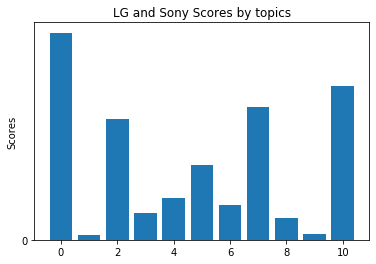

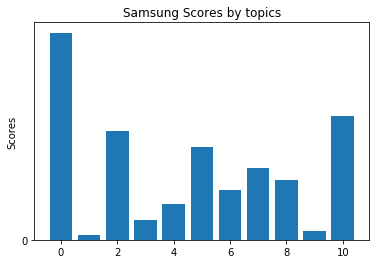

In [31]:
chart_builder(non_topics,num_topics,'LG and Sony ')
chart_builder(samsung_topics,num_topics,'Samsung ')

In [33]:
difference = np.subtract(samsung_topics, non_topics)
pprint(difference)

def get_topics(list, num_topics):
    a = []
    for i in range(len(list)):
        if list[i] > 0.025 or list[i] < -0.025:
            a.append(num_topics[i])
            
    return a

topics = get_topics(difference, num_topics)
print(topics)

array([ 0.01350531,  0.00096756, -0.00754647, -0.00682418, -0.00561081,
        0.02869994,  0.02106033, -0.069034  ,  0.05051115,  0.00348429,
       -0.02921311])
['topic_5', 'topic_7', 'topic_8', 'topic_10']
